In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import fnmatch
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display
from sklearn.manifold import TSNE
import json

In [2]:
path = 'F:\Music_Notes'

In [3]:
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.wav'):
        files.append(os.path.join(root, filename))

print("found %d .wav files in %s"%(len(files),path))

found 246 .wav files in F:\Music_Notes


In [4]:
def get_features(y, sr):
    y = y[0:sr]
    S = librosa.feature.melspectrogram(y,sr=sr, n_mels=128)
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    delta_mfcc = librosa.feature.delta(mfcc, mode='nearest')
    delta2_mfcc = librosa.feature.delta(mfcc, order=2, mode='nearest')
    feature_vector = np.concatenate((np.mean(mfcc,1), np.mean(delta_mfcc,1), np.mean(delta2_mfcc,1)))
    feature_vector = (feature_vector-np.mean(feature_vector)) / np.std(feature_vector)
    return feature_vector

In [5]:
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    if i % 100 == 0: # this was because there were 6000 sounds in original dataset and printing every single is lengthy
        print("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f)
        if len(y) < 2:
            print("error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except:
        print("error loading %s" % f)
        
print("calculated %d feature vectors"%len(feature_vectors))
n = len(feature_vectors)

get 1 of 246 = F:\Music_Notes\072_the-mystery-begins-guitar-space.wav
get 101 of 246 = F:\Music_Notes\Clapping.wav
get 201 of 246 = F:\Music_Notes\pingpong.wav
calculated 246 feature vectors


In [6]:
print(len(feature_vectors[0]))

39


In [7]:
model = TSNE(n_components=2, learning_rate=150, perplexity=2, verbose=2, angle=0.1).fit_transform(feature_vectors)

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 246 samples in 0.178s...
[t-SNE] Computed neighbors for 246 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 246 / 246
[t-SNE] Mean sigma: 0.065810
[t-SNE] Computed conditional probabilities in 0.062s
[t-SNE] Iteration 50: error = 92.5858612, gradient norm = 0.4683978 (50 iterations in 0.323s)
[t-SNE] Iteration 100: error = 88.0796814, gradient norm = 0.5039044 (50 iterations in 0.186s)
[t-SNE] Iteration 150: error = 83.9874649, gradient norm = 0.4556319 (50 iterations in 0.248s)
[t-SNE] Iteration 200: error = 84.1196213, gradient norm = 0.4324990 (50 iterations in 0.215s)
[t-SNE] Iteration 250: error = 82.8387375, gradient norm = 0.4178329 (50 iterations in 0.210s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.838737
[t-SNE] Iteration 300: error = 1.4990472, gradient norm = 0.0181010 (50 iterations in 0.206s)
[t-SNE] Iteration 350: error = 1.0914719, gradient norm = 0.0079113 (5

In [8]:
names = [None]*n
i = 0
for note in files:
    spl = note.split("\\")
    x = spl[2].split(".")
    names[i] = x[0]
    i+=1

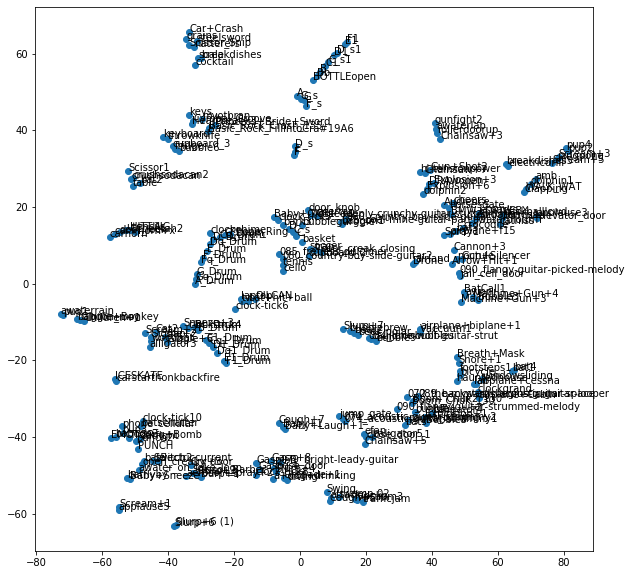

In [9]:
x_axis=model[:,0]
y_axis=model[:,1]
plt.figure(figsize = (10,10))
plt.scatter(x_axis, y_axis)
for i, txt in enumerate(names):
    plt.annotate(txt, (x_axis[i], y_axis[i]))
plt.show()

In [10]:
from matplotlib.widgets import Button

<IPython.core.display.Javascript object>


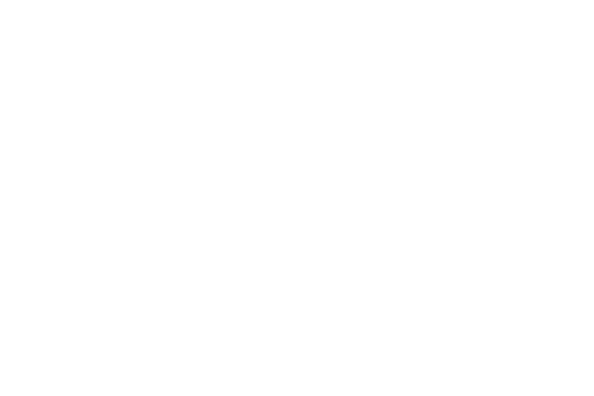

<IPython.core.display.Javascript object>


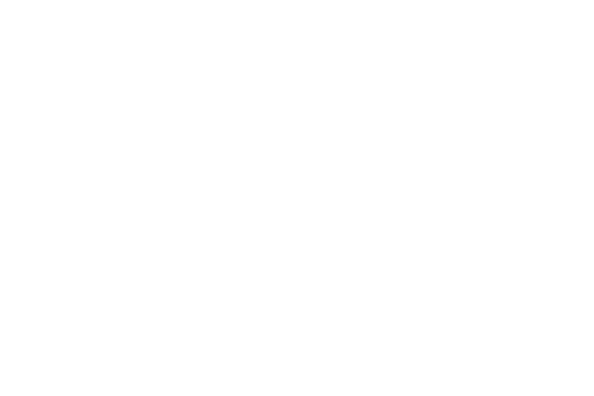

In [11]:
import winsound
import matplotlib.pyplot as plt
%matplotlib nbagg
import numpy as np; np.random.seed(1)
import mpld3
x = x_axis
y = y_axis

names = np.array(names)
c = np.random.randint(1,5,size=n)

norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn

fig,ax = plt.subplots()
sc = plt.scatter(x,y,c=c,s=n, cmap=cmap, norm=norm)
ax.set_facecolor("black")

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            winsound.PlaySound(sound_paths[ind["ind"][0]], winsound.SND_ASYNC | winsound.SND_ALIAS )
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                winsound.PlaySound(None, winsound.SND_ASYNC)
                fig.canvas.draw_idle()



fig.canvas.mpl_connect("motion_notify_event", hover)

import plotly.graph_objects as go
f = go.FigureWidget([go.Scatter(x=x, y=y, mode='markers')])
scatter = f.data[0]
colors = ['#a3a7e4'] * 100
scatter.marker.color = colors
scatter.marker.size = [10] * 100
f.layout.hovermode = 'closest'


# create our callback function
def update_point(trace, points, selector):
    print("hell yes")
    c = list(scatter.marker.color)
    s = list(scatter.marker.size)
    for i in points.point_inds:
        c[i] = '#bae2be'
        s[i] = 20
        with f.batch_update():
            scatter.marker.color = c
            scatter.marker.size = s

scatter.on_click(update_point)
plt.show()

In [12]:
colr = []
for  k in range(n):
    if(int(x[k]) < -60):
        if(int(y[k]) < -60):
            colr.append("darkblue")
        elif(y[k] < -40):
            colr.append("mediumspringgreen")
        elif(y[k] < -20):
            colr.append("royalblue")
        elif(y[k] < 0):
            colr.append("palegreen")
        elif(y[k] < 20):
            colr.append("darkorchid")
        elif(y[k] < 40):
            colr.append("darkgrey")
        elif(y[k] < 60):
            colr.append("indianred")
        else:
            colr.append("choclate")
    elif(x[k] < -40):
        if(int(y[k]) < -60):
            colr.append("darkorchid")
        elif(y[k] < -40):
            colr.append("darkkhaki")
        elif(y[k] < -20):
            colr.append("mediumvioletred")
        elif(y[k] < 0):
            colr.append("goldenrod")
        elif(y[k] < 20):
            colr.append("maroon")
        elif(y[k] < 40):
            colr.append("violet")
        elif(y[k] < 60):
            colr.append("burlywood")
        else:
            colr.append("purple")
    elif(x[k] < -20):
        if(int(y[k]) < -60):
            colr.append("green")
        elif(y[k] < -40):
            colr.append("seagreen")
        elif(y[k] < -20):
            colr.append("yellow")
        elif(y[k] < 0):
            colr.append("blue")
        elif(y[k] < 20):
            colr.append("lightgreen")
        elif(y[k] < 40):
            colr.append("brown")
        elif(y[k] < 60):
            colr.append("fuchsia")
        else:
            colr.append("purple")
    elif(x[k] < 0):
        if(int(y[k]) < -60):
            colr.append("sandybrown")
        elif(y[k] < -40):
            colr.append("cornsilk")
        elif(y[k] < -20):
            colr.append("pink")
        elif(y[k] < 0):
            colr.append("magenta")
        elif(y[k] < 20):
            colr.append("khaki")
        elif(y[k] < 40):
            colr.append("brown")
        elif(y[k] < 60):
            colr.append("lavender")
        else:
            colr.append("plum")
    elif(x[k] < 20):
        if(int(y[k]) < -60):
            colr.append("green")
        elif(y[k] < -40):
            colr.append("seagreen")
        elif(y[k] < -20):
            colr.append("yellow")
        elif(y[k] < 0):
            colr.append("blue")
        elif(y[k] < 20):
            colr.append("seagreen")
        elif(y[k] < 40):
            colr.append("brown")
        elif(y[k] < 60):
            colr.append("fuchsia")
        else:
            colr.append("purple")
    elif(x[k] < 40):
        if(int(y[k]) < -60):
            colr.append("gainsboro")
        elif(y[k] < -40):
            colr.append("palevioletred")
        elif(y[k] < -20):
            colr.append("silver")
        elif(y[k] < 0):
            colr.append("rosybrown")
        elif(y[k] < 20):
            colr.append("peru")
        elif(y[k] < 40):
            colr.append("tan")
        elif(y[k] < 60):
            colr.append("gray")
        else:
            colr.append("lawngreen")
    elif(x[k] < 60):
        if(int(y[k]) < -60):
            colr.append("lightslategray")
        elif(y[k] < -40):
            colr.append("olivedrab")
        elif(y[k] < -20):
            colr.append("yellow")
        elif(y[k] < 0):
            colr.append("cornflowerblue")
        elif(y[k] < 20):
            colr.append("lightskyblue")
        elif(y[k] < 40):
            colr.append("indigo")
        elif(y[k] < 60):
            colr.append("fuchsia")
        else:
            colr.append("purple")
    else:
        if(int(y[k]) < -60):
            colr.append("green")
        elif(y[k] < -40):
            colr.append("seagreen")
        elif(y[k] < -20):
            colr.append("mediumturquoise")
        elif(y[k] < 0):
            colr.append("forestgreen")
        elif(y[k] < 20):
            colr.append("lightskyblue")
        elif(y[k] < 40):
            colr.append("brown")
        elif(y[k] < 60):
            colr.append("fuchsia")
        else:
            colr.append("purple")
    
    

In [13]:
from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.models import CustomJSHover

from math import sin
from random import random

from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.palettes import plasma
from bokeh.transform import transform

from bokeh import events
from bokeh.layouts import column, row
from bokeh.models import Button, CustomJS, Div, Slider

from bokeh.events import Tap
from bokeh.models.callbacks import CustomJS

from bokeh.resources import Resources
from bokeh.io.state import curstate
from bokeh.io import curdoc, save
from bokeh.util.browser import view
from bokeh.models.widgets import Panel, Tabs


from bokeh.models import RadioGroup
from bokeh.models import Toggle


In [14]:

class MyResources(Resources):
    @property
    def css_raw(self):
        return super().css_raw + [
            """.bk-root {
                    background-color: #A9A9A9;
                    border-color: #000000;
                    }
                
            """
        ]

In [15]:
output_file("openurl.html")

curstate().file['resources'] = MyResources(mode='cdn')
#save(tabs)
#view("./openurl.html")




source = ColumnDataSource(data=dict(
    x=x,
    y=y,
    label = names,
    spath = files,
    color = colr
    ))
i = 4;
#for a datapoint information
TOOLTIPS = """
    <div>
        <div style = "display : none">
            <audio id = "myAudio" controls autoplay>
              <source src= @spath>
            </audio>
        </div>
        <div>
            <span id="song_index" style="font-size: 15px; color: #966;">$index</span>
            <span style="font-size: 17px; font-weight: bold;">@label</span>
        </div>
    </div>
"""

hover = HoverTool(tooltips=TOOLTIPS, show_arrow=False)
fig = figure(plot_width=1100, plot_height=500,
           tools= [hover], title="Click the Dots")
fig.background_fill_color = "black"

fig.grid.grid_line_color = None
fig.circle('x', 'y', color='color', size=10, source=source)

def display_event(div,div3,div4,div5,div6,attributes=[], style = 'float:left;clear:left;font_size=13px'):
    "Build a suitable CustomJS to display the current event in the div model."
    return CustomJS(args=dict(div=div,div3=div3,div4=div4,div5=div5,div6=div6,s2=s2,source=source), code="""
        var attrs = %s; var args = [];
        var tune_list = s2.data['tune'];
        var colr = source.data['color'];
        var indx = parseInt(document.getElementById("song_index").innerHTML);
        var fsong = source.data['spath'];
        for (var i = 0; i<attrs.length; i++) {
            args.push(attrs[i] + '=' + Number(cb_obj[attrs[i]]).toFixed(2));
        }
        var line = "<span style=%r><b>" + cb_obj.event_name + "</b>(" + args.join(", ") + ")</span>\\n";
        var z = cb_obj.event_name;
        if(z == "tap"){
           var nm = source.data['label'];
           tune_list.push(fsong[indx].replace(/\\\/g,"/"));
           var l = tune_list.length;
           if(l == 1)
               div3.text = nm[indx];
            if(l == 2)
               div4.text = nm[indx];
            if(l == 3)
               div5.text = nm[indx];
            if(l == 4)
               div6.text = nm[indx];
           colr[indx] = "red";
           }
           
        var text = div.text.concat(line);
        var lines = text.split("\\n")
        if(tune_list.length != 4)
            div.text = lines.join("\\n")  + tune_list + " length = "+tune_list.length;
        else
            div.text =  "You can Play the song";
        s2.change.emit();
        source.change.emit();
    """ % (attributes,style))
  
def play_song(div,checkbox_1,checkbox_2,checkbox_3,checkbox_4):
    "Build a suitable CustomJS to display the current event in the div model."
    return CustomJS(args=dict(div=div,checkbox_1=checkbox_1,checkbox_2=checkbox_2,checkbox_3=checkbox_3,checkbox_4=checkbox_4,s1=s2,s6=s5), code="""
        var list_song = s1.data['tune'];
        var txt = "";
         
         for(var song of list_song){
             txt += song + "<br>";
        }
        div.text = "The tune will be played in loop<br>" + txt;
       
        // sleep time expects milliseconds
        function sleep (time) {
          return new Promise((resolve) => setTimeout(resolve, time));
        }
         var t3 = s6.data['t3'];
         var t = t3[0];
        // var t = 250;
        var audio1, audio2, audio3, audio4;
        var ind = 0;
            function play1(q,t){
                sleep(t*q).then(() => {                            
                     audio1 = new Audio(list_song[0]);
                     audio1.play();
                });
                sleep(t*q + t).then(() => {
                     audio1.pause();
                });
            }
            function play2(q,t){
                sleep(t*q).then(() => {                            
                     audio2 = new Audio(list_song[1]);
                     audio2.play();
                });
                sleep(t*q + t).then(() => {
                     audio2.pause();
                });
            }
            function play3(q,t){
                sleep(t*q).then(() => {                            
                     audio3 = new Audio(list_song[2]);
                     audio3.play();
                });
                sleep(t*q + t).then(() => {
                     audio3.pause();
                });
            }
            function play4(q,t){
                sleep(t*q).then(() => {                            
                     audio4 = new Audio(list_song[3]);
                     audio4.play();
                });
                sleep(t*q + t).then(() => {
                     audio4.pause();
                });
            }
            var i=0,j=0,l=0,m=0;
            var n1 = checkbox_1.active.length;
            var n2 = checkbox_2.active.length;
            var n3 = checkbox_3.active.length;
            var n4 = checkbox_4.active.length;
            checkbox_1.active.sort();
            checkbox_2.active.sort();
            checkbox_3.active.sort();
            checkbox_4.active.sort();
            for(var q = 0; q <= 15; q++){
                   var a1 = false, a2 = false, a3 = false, a4 = false;
               if(i < n1)
                   a1 = checkbox_1.active.includes(q);
               if(j < n2)
                   a2 = checkbox_2.active.includes(q);
               if(l < n3)
                   a3 = checkbox_3.active.includes(q);
               if(m < n4)
                   a4 = checkbox_4.active.includes(q);
                   
               if(a1 && a2 && a3 && a4){
                   play1(q,t);
                   play2(q,t);
                   play3(q,t);
                   play4(q,t);
                   i++;j++;l++;m++;
               }
               else if(a1 && a2 && a3){
                   play1(q,t);
                   play2(q,t);
                   play3(q,t);
                   i++;j++;l++;
               }
               else if(a1 && a2 && a4){
                   play1(q,t);
                   play2(q,t);
                   play4(q,t);
                   i++;j++;m++;
               }                 
               else if(a1 && a3 && a4){
                   play1(q,t);
                   play3(q,t);
                   play4(q,t);
                   i++;l++;m++;
               }
               else if(a2 && a3 && a4){
                   play2(q,t);
                   play3(q,t);
                   play4(q,t);
                   j++;l++;m++;
               }
               else if(a1 && a2){
                   play1(q,t);
                   play2(q,t);
                   i++;j++;
               }
               else if(a1 && a3){
                   play1(q,t);
                   play3(q,t);
                   i++;l++;
               }
               else if(a1 && a4){
                   play1(q,t);
                   play4(q,t);
                   i++;m++;
               }
               else if(a2 && a3){
                   play2(q,t);
                   play3(q,t);
                   j++;l++;
               }
               else if(a2 && a4){
                   play2(q,t);
                   play4(q,t);
                  j++;m++;
               }
               else if(a3 && a4){
                   play3(q,t);
                   play4(q,t);
                   l++;m++;
               }
               else if(a1){
                   play1(q,t);
                   i++;
               }
               else if(a2){
                   play2(q,t);
                   j++;
               }
               else if(a3){
                   play3(q,t);
                   l++;
               }
               else if(a4){
                   play4(q,t);
                   m++;
               }
            }
           
    """) 

def clear_song(div,div3,div4,div5,div6):
    "Build a suitable CustomJS to display the current event in the div model."
    return CustomJS(args=dict(div=div,div3=div3,div4=div4,div5=div5,div6=div6,s4=s2), code="""
        var list_song = s4.data['tune'];       
        list_song.length = 0;
        div.text = "Clear All";
        div3.text = "";
        div4.text = "";
        div5.text = "";
        div6.text = "";
       s2.change.emit();
    """) 

t3 = [400]
s5 = ColumnDataSource(data=dict(t3 = t3))
speed_slider = Slider(start=100, end=1000, value=400, step=25, title="Tune Speed")

speed_slider.callback = CustomJS(args=dict(s7=s5, speed=speed_slider),
                    code="""
    var t3 = s7.data['t3'];
    t3[0] = this.value;
    s5.change.emit();
""")

tune = []
s2 = ColumnDataSource(data=dict(tune = tune))

div = Div(width=400, height=fig.plot_height, height_policy="fixed")
button = Button(label="Play the tune", button_type="success")
button1 = Button(label="Clear", button_type="success")
from bokeh.models import CheckboxButtonGroup

checkbox_1 = CheckboxButtonGroup(
        labels=["1", "2", "3","4","5","6","7","8","9","10","11","12","13","14","15","16"], active=[1,2,3,6])
checkbox_2 = CheckboxButtonGroup(
        labels=["1", "2", "3","4","5","6","7","8","9","10","11","12","13","14","15","16"], active=[0,4,5,7,10])
checkbox_3 = CheckboxButtonGroup(
        labels=["1", "2", "3","4","5","6","7","8","9","10","11","12","13","14","15","16"], active=[7,8,11,13])
checkbox_4 = CheckboxButtonGroup(
        labels=["1", "2", "3","4","5","6","7","8","9","10","11","12","13","14","15","16"], active=[9,11,12,15])

#checkbox_1.labels[0] = "45";
#checkbox_1.active = list(range(10))
div3 = Div(width=100, height=15, height_policy="fixed")
div4 = Div(width=100, height=15, height_policy="fixed")
div5 = Div(width=100, height=15, height_policy="fixed")
div6 = Div(width=100, height=15, height_policy="fixed")

layout = column(row(fig, div),row(button,button1,speed_slider),
                row(div3,checkbox_1,sizing_mode = "stretch_width"),
                row(div4,checkbox_2,sizing_mode = "stretch_width"),
                row(div5,checkbox_3,sizing_mode = "stretch_width"),
                row(div6,checkbox_4,sizing_mode = "stretch_width"))

## Events with no attributes
button.js_on_event(events.ButtonClick, play_song(div,checkbox_1,checkbox_2,checkbox_3,checkbox_4)) # Button click
button1.js_on_event(events.ButtonClick, clear_song(div,div3,div4,div5,div6)) # Button click
fig.js_on_event(events.LODStart, display_event(div,div3,div4,div5,div6))         # Start of LOD display
fig.js_on_event(events.LODEnd, display_event(div,div3,div4,div5,div6))           # End of LOD display
#speed_slider.js_on_change('value', callback)
## Events with attributes
point_attributes = ['x', 'y', 'sx', 'sy']                  # Point events
pan_attributes = point_attributes + ['delta_x', 'delta_y'] # Pan event

point_events = [events.Tap,]

for event in point_events:
    fig.js_on_event(event, display_event(div,div3,div4,div5,div6,attributes = point_attributes))

fig.js_on_event(events.Pan, display_event(div, div3,div4,div5,div6, attributes=pan_attributes))

#url = "http://www.colors.commutercreative.com/@color/"
#taptool = fig.select(type=TapTool)
#taptool.callback = OpenURL(url=url)

show(layout)                                    #shows you the visualization